In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


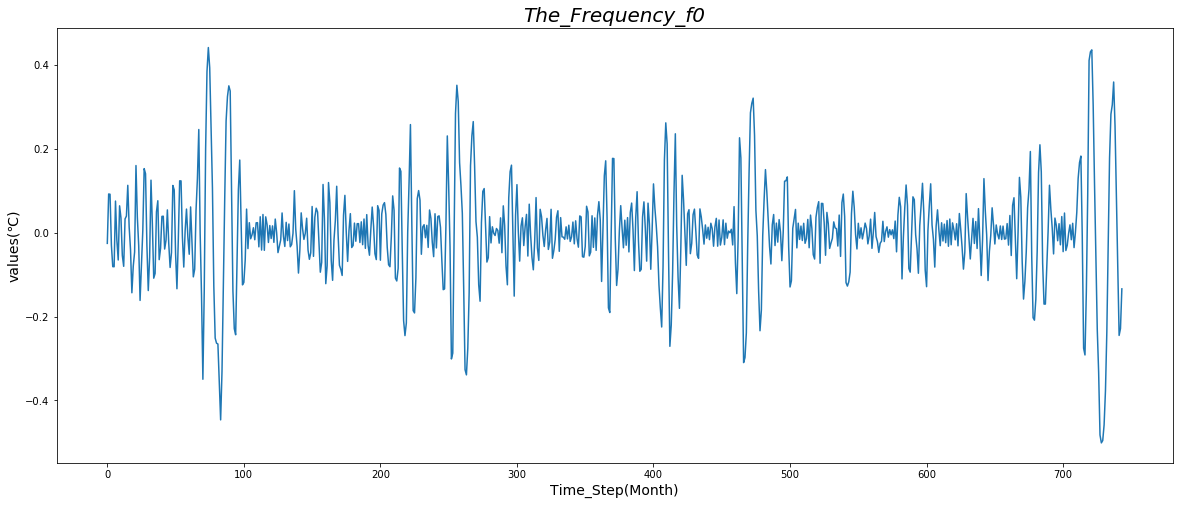

(696, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 19s - loss: 0.0121
Epoch 2/200
 - 4s - loss: 0.0121
Epoch 3/200
 - 3s - loss: 0.0121
Epoch 4/200
 - 4s - loss: 0.0121
Epoch 5/200
 - 4s - loss: 0.0121
Epoch 6/200
 - 3s - loss: 0.0120
Epoch 7/200
 - 4s - loss: 0.0120
Epoch 8/200
 - 3s - loss: 0.0120
Epoch 9/200
 - 3s - loss: 0.0120
Epoch 10/200
 - 4s - loss: 0.0119
Epoch 11/200
 - 4s - loss: 0.0122
Epoch 12/200
 - 4s - loss: 0.0120
Epoch 13/200
 - 4s - loss: 0.0118
Epoch 14/200
 - 4s - loss: 0.0116
Epoch 15/200
 - 4s - loss: 0.0113
Epoch 16/200
 - 3s - loss: 0.0112
Epoch 17/200
 - 3s - loss: 0.0113
Epoch 18/200
 - 3s - loss: 0.0109
Epoch 19/200
 - 4s - loss: 0.0108
Epoch 20/200
 - 4s - loss: 0.0107
Epoch 21/200
 - 4s - loss: 0.0104
Epoch 22/200
 - 4s - loss: 0.0107
Epoch 23/200

(59, 12)


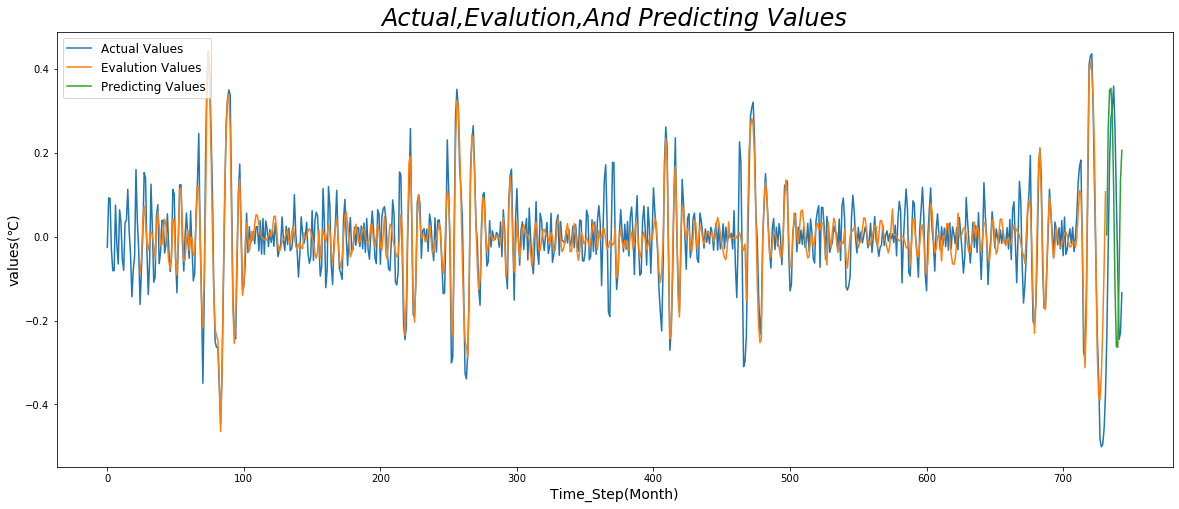

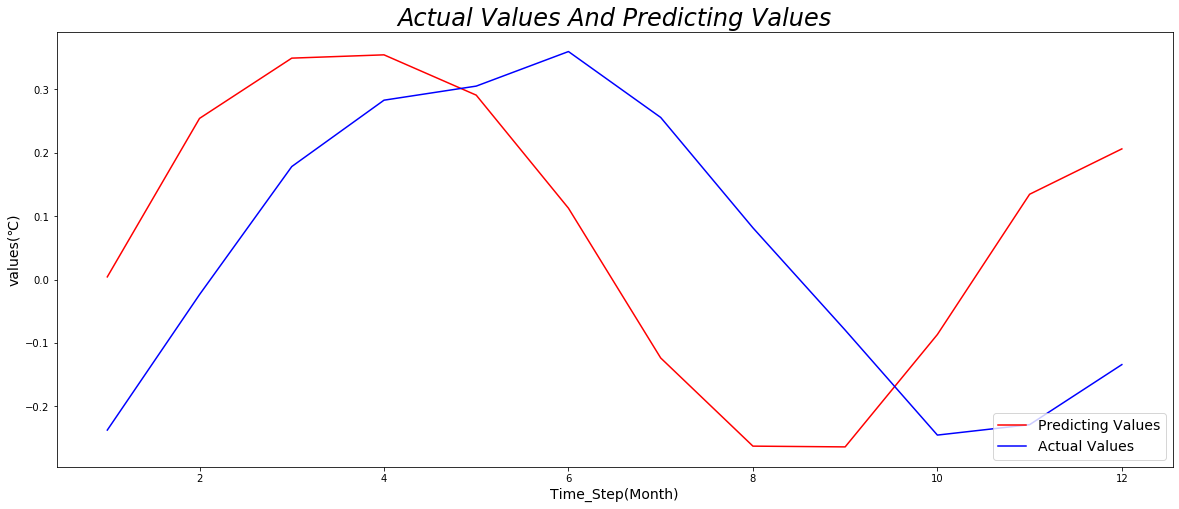

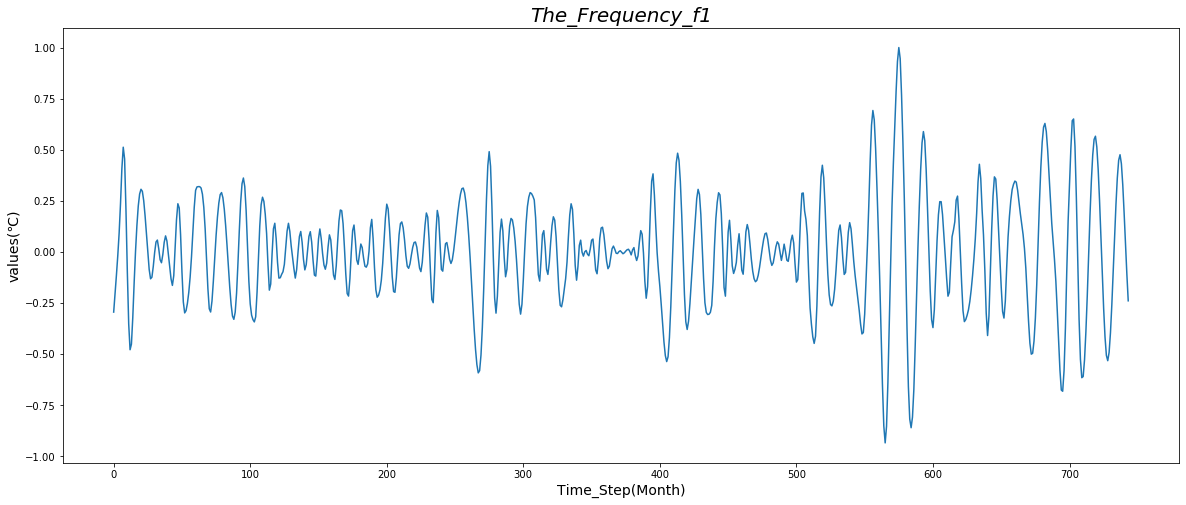

(696, 24, 1)
Epoch 1/200
 - 16s - loss: 0.0657
Epoch 2/200
 - 3s - loss: 0.0635
Epoch 3/200
 - 4s - loss: 0.0537
Epoch 4/200
 - 4s - loss: 0.0468
Epoch 5/200
 - 3s - loss: 0.0436
Epoch 6/200
 - 3s - loss: 0.0412
Epoch 7/200
 - 4s - loss: 0.0403
Epoch 8/200
 - 3s - loss: 0.0385
Epoch 9/200
 - 3s - loss: 0.0380
Epoch 10/200
 - 3s - loss: 0.0384
Epoch 11/200
 - 3s - loss: 0.0358
Epoch 12/200
 - 3s - loss: 0.0351
Epoch 13/200
 - 3s - loss: 0.0329
Epoch 14/200
 - 3s - loss: 0.0336
Epoch 15/200
 - 3s - loss: 0.0312
Epoch 16/200
 - 3s - loss: 0.0323
Epoch 17/200
 - 3s - loss: 0.0341
Epoch 18/200
 - 3s - loss: 0.0317
Epoch 19/200
 - 3s - loss: 0.0294
Epoch 20/200
 - 3s - loss: 0.0296
Epoch 21/200
 - 4s - loss: 0.0290
Epoch 22/200
 - 3s - loss: 0.0303
Epoch 23/200
 - 3s - loss: 0.0304
Epoch 24/200
 - 3s - loss: 0.0296
Epoch 25/200
 - 3s - loss: 0.0288
Epoch 26/200
 - 3s - loss: 0.0286
Epoch 27/200
 - 3s - loss: 0.0271
Epoch 28/200
 - 3s - loss: 0.0265
Epoch 29/200
 - 3s - loss: 0.0267
Epoch 30/

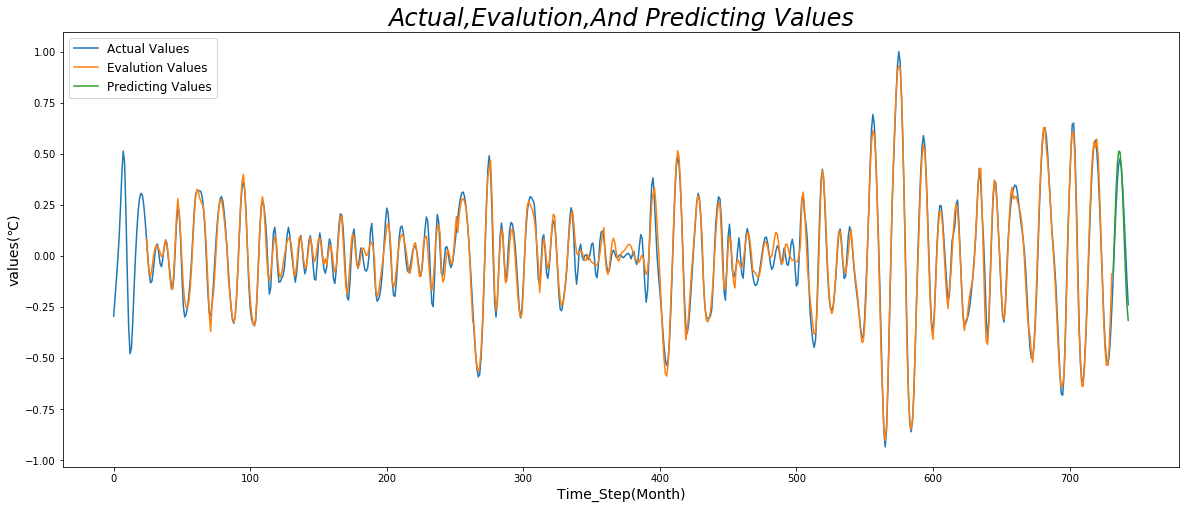

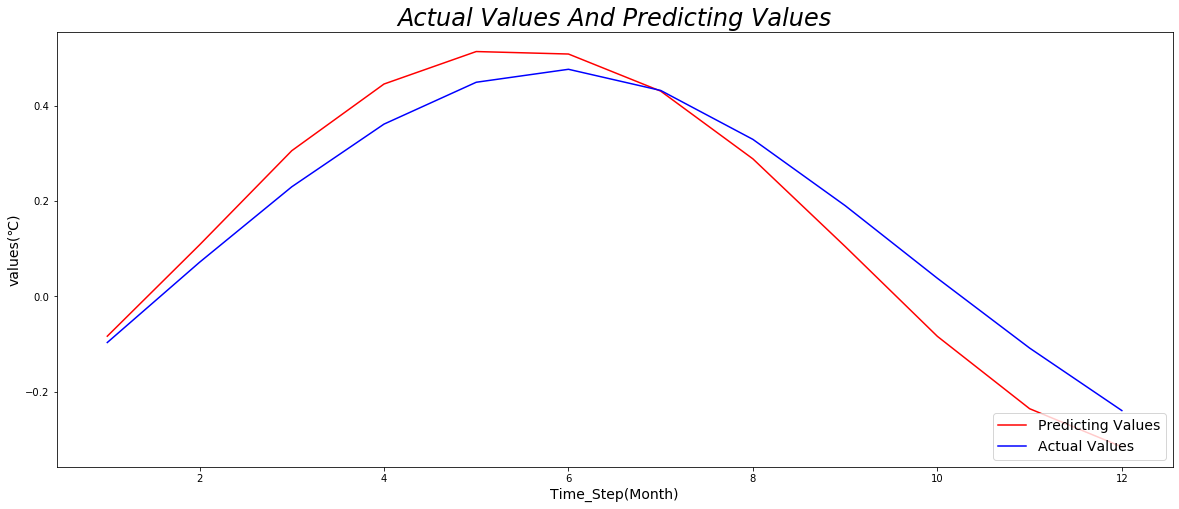

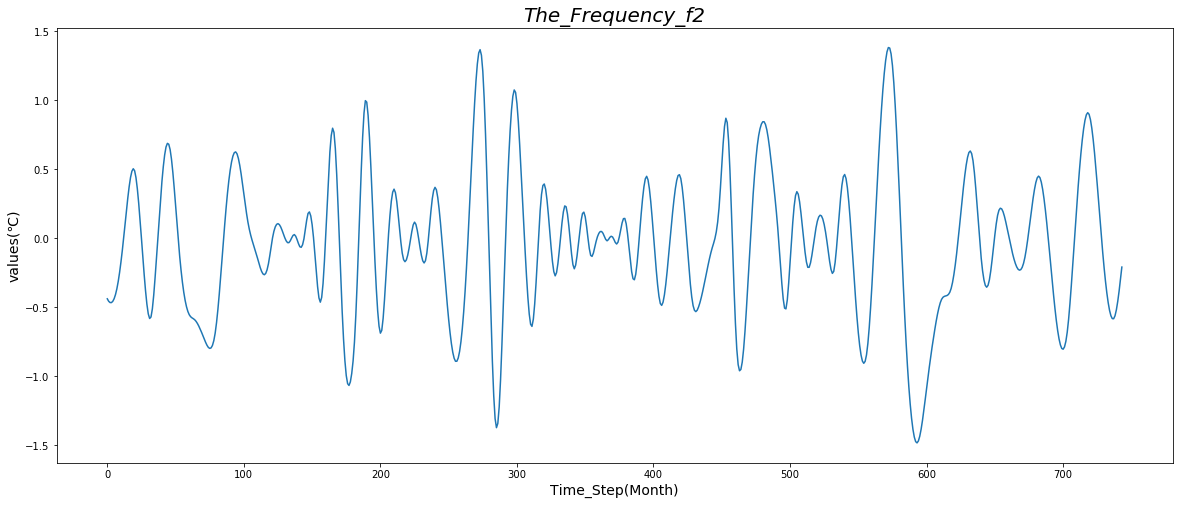

(696, 24, 1)
Epoch 1/200
 - 6s - loss: 0.2599
Epoch 2/200
 - 3s - loss: 0.2417
Epoch 3/200
 - 3s - loss: 0.2330
Epoch 4/200
 - 3s - loss: 0.1951
Epoch 5/200
 - 3s - loss: 0.1535
Epoch 6/200
 - 3s - loss: 0.1344
Epoch 7/200
 - 4s - loss: 0.1255
Epoch 8/200
 - 4s - loss: 0.1179
Epoch 9/200
 - 4s - loss: 0.1099
Epoch 10/200
 - 4s - loss: 0.0985
Epoch 11/200
 - 4s - loss: 0.0980
Epoch 12/200
 - 4s - loss: 0.0879
Epoch 13/200
 - 4s - loss: 0.0862
Epoch 14/200
 - 4s - loss: 0.0802
Epoch 15/200
 - 4s - loss: 0.0829
Epoch 16/200
 - 4s - loss: 0.0789
Epoch 17/200
 - 4s - loss: 0.0794
Epoch 18/200
 - 4s - loss: 0.0795
Epoch 19/200
 - 4s - loss: 0.0727
Epoch 20/200
 - 4s - loss: 0.0654
Epoch 21/200
 - 4s - loss: 0.0666
Epoch 22/200
 - 4s - loss: 0.0641
Epoch 23/200
 - 4s - loss: 0.0562
Epoch 24/200
 - 4s - loss: 0.0566
Epoch 25/200
 - 4s - loss: 0.0548
Epoch 26/200
 - 4s - loss: 0.0686
Epoch 27/200
 - 4s - loss: 0.0556
Epoch 28/200
 - 4s - loss: 0.0528
Epoch 29/200
 - 4s - loss: 0.0501
Epoch 30/2

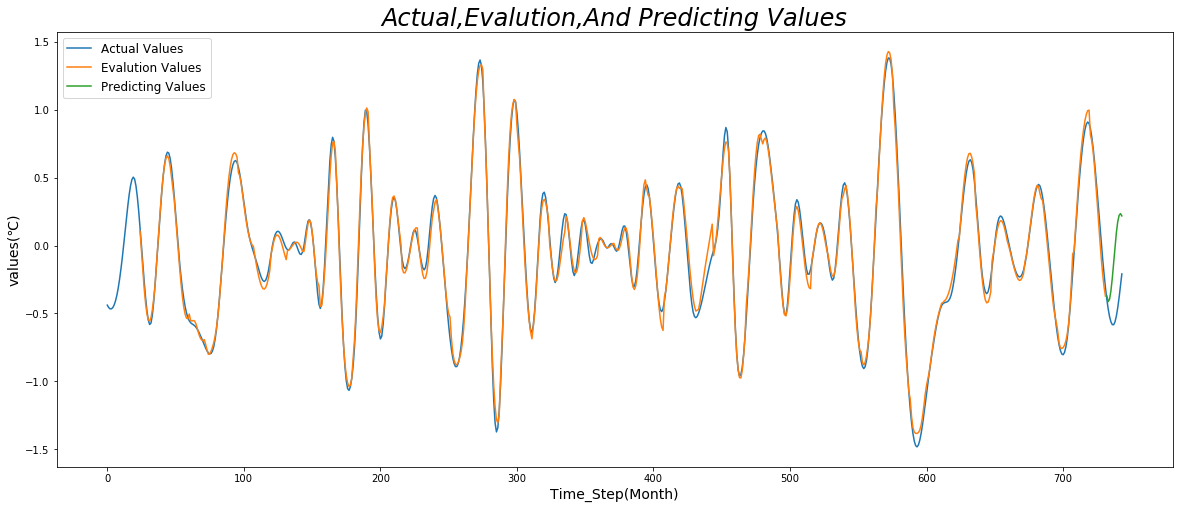

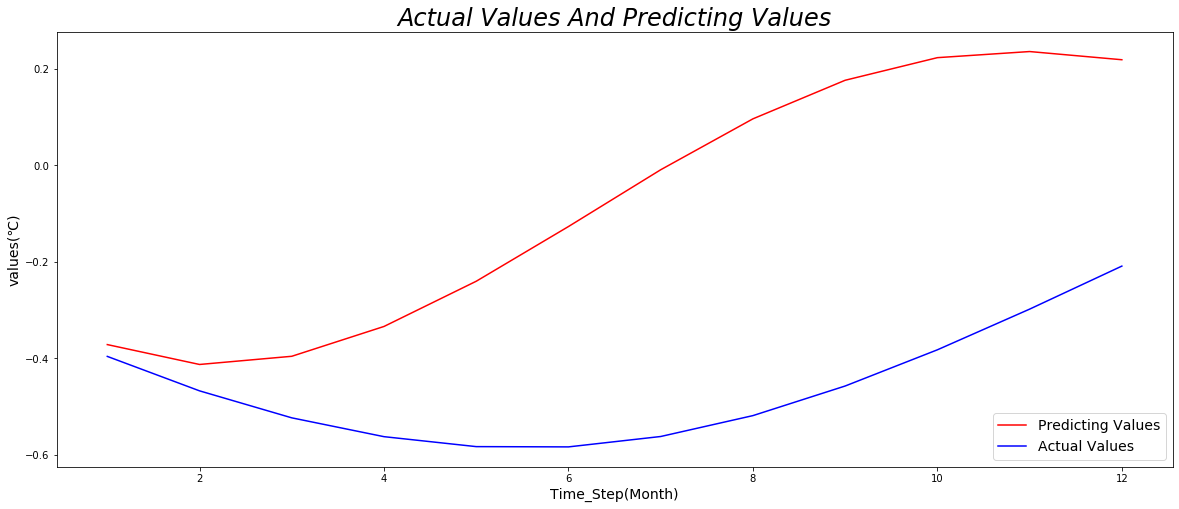

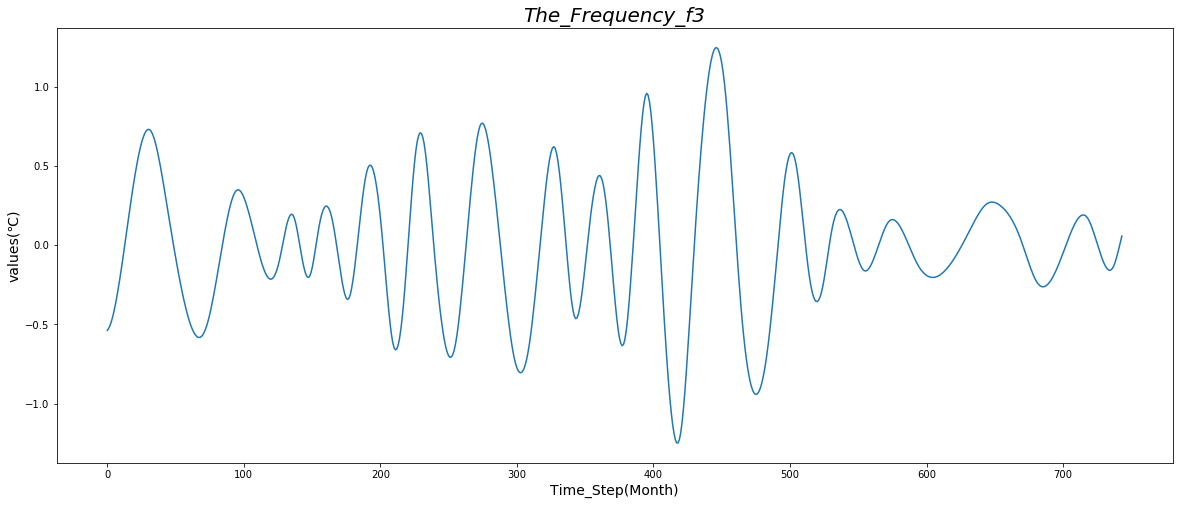

(696, 24, 1)
Epoch 1/200
 - 14s - loss: 0.1574
Epoch 2/200
 - 5s - loss: 0.1225
Epoch 3/200
 - 5s - loss: 0.0900
Epoch 4/200
 - 5s - loss: 0.0679
Epoch 5/200
 - 5s - loss: 0.0538
Epoch 6/200
 - 4s - loss: 0.0430
Epoch 7/200
 - 3s - loss: 0.0413
Epoch 8/200
 - 3s - loss: 0.0345
Epoch 9/200
 - 3s - loss: 0.0269
Epoch 10/200
 - 3s - loss: 0.0248
Epoch 11/200
 - 3s - loss: 0.0231
Epoch 12/200
 - 4s - loss: 0.0200
Epoch 13/200
 - 5s - loss: 0.0183
Epoch 14/200
 - 4s - loss: 0.0262
Epoch 15/200
 - 5s - loss: 0.0201
Epoch 16/200
 - 5s - loss: 0.0168
Epoch 17/200
 - 5s - loss: 0.0170
Epoch 18/200
 - 5s - loss: 0.0198
Epoch 19/200
 - 5s - loss: 0.0216
Epoch 20/200
 - 5s - loss: 0.0149
Epoch 21/200
 - 5s - loss: 0.0134
Epoch 22/200
 - 5s - loss: 0.0146
Epoch 23/200
 - 5s - loss: 0.0123
Epoch 24/200
 - 4s - loss: 0.0130
Epoch 25/200
 - 5s - loss: 0.0135
Epoch 26/200
 - 4s - loss: 0.0112
Epoch 27/200
 - 5s - loss: 0.0118
Epoch 28/200
 - 5s - loss: 0.0110
Epoch 29/200
 - 4s - loss: 0.0117
Epoch 30/

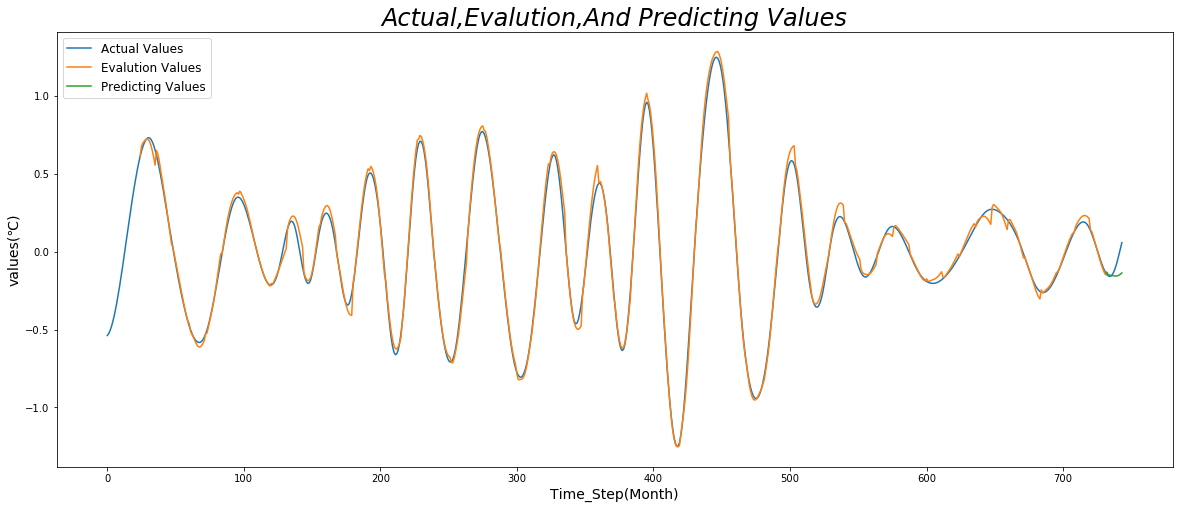

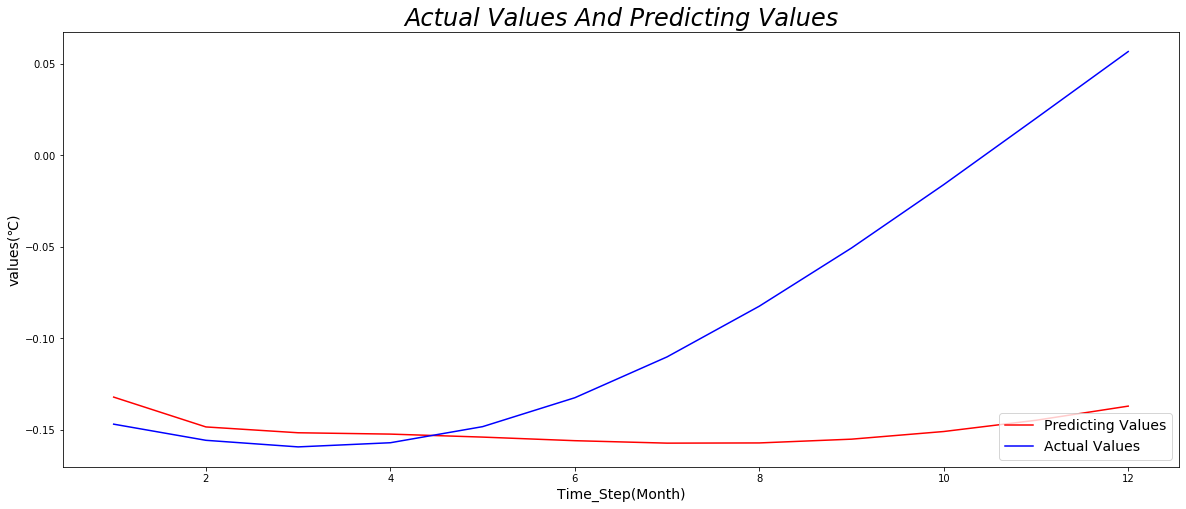

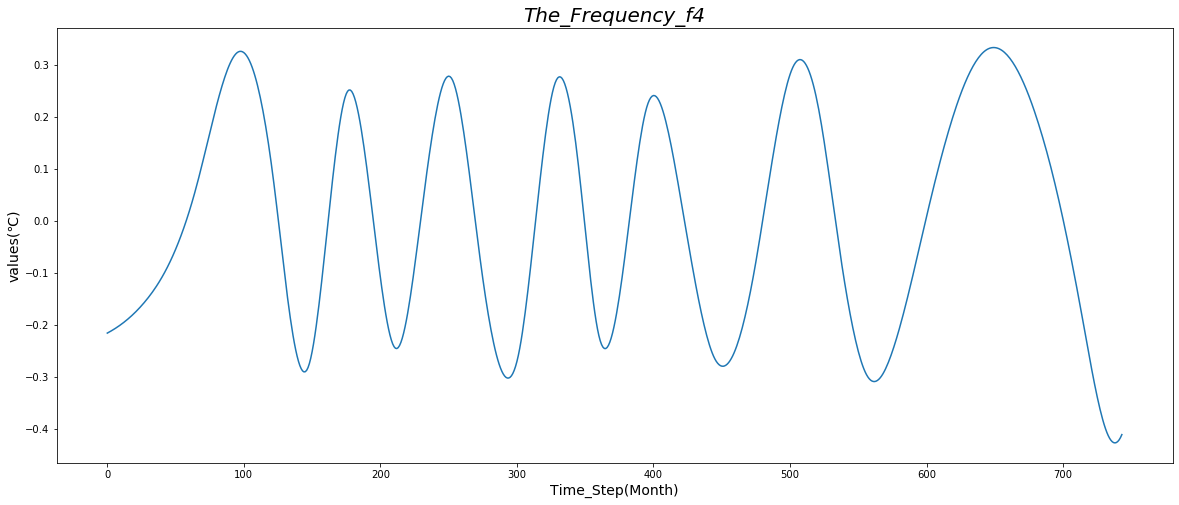

(696, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0312
Epoch 2/200
 - 5s - loss: 0.0139
Epoch 3/200
 - 5s - loss: 0.0068
Epoch 4/200
 - 5s - loss: 0.0047
Epoch 5/200
 - 5s - loss: 0.0036
Epoch 6/200
 - 4s - loss: 0.0033
Epoch 7/200
 - 4s - loss: 0.0035
Epoch 8/200
 - 4s - loss: 0.0024
Epoch 9/200
 - 4s - loss: 0.0026
Epoch 10/200
 - 5s - loss: 0.0027
Epoch 11/200
 - 5s - loss: 0.0023
Epoch 12/200
 - 5s - loss: 0.0020
Epoch 13/200
 - 5s - loss: 0.0014
Epoch 14/200
 - 5s - loss: 0.0013
Epoch 15/200
 - 5s - loss: 0.0012
Epoch 16/200
 - 5s - loss: 0.0015
Epoch 17/200
 - 5s - loss: 0.0013
Epoch 18/200
 - 5s - loss: 0.0018
Epoch 19/200
 - 5s - loss: 0.0017
Epoch 20/200
 - 5s - loss: 0.0018
Epoch 21/200
 - 5s - loss: 0.0017
Epoch 22/200
 - 5s - loss: 0.0017
Epoch 23/200
 - 5s - loss: 0.0013
Epoch 24/200
 - 5s - loss: 0.0012
Epoch 25/200
 - 5s - loss: 0.0012
Epoch 26/200
 - 5s - loss: 0.0011
Epoch 27/200
 - 5s - loss: 0.0011
Epoch 28/200
 - 5s - loss: 0.0013
Epoch 29/200
 - 5s - loss: 9.3722e-04
Epoch

(59, 12)


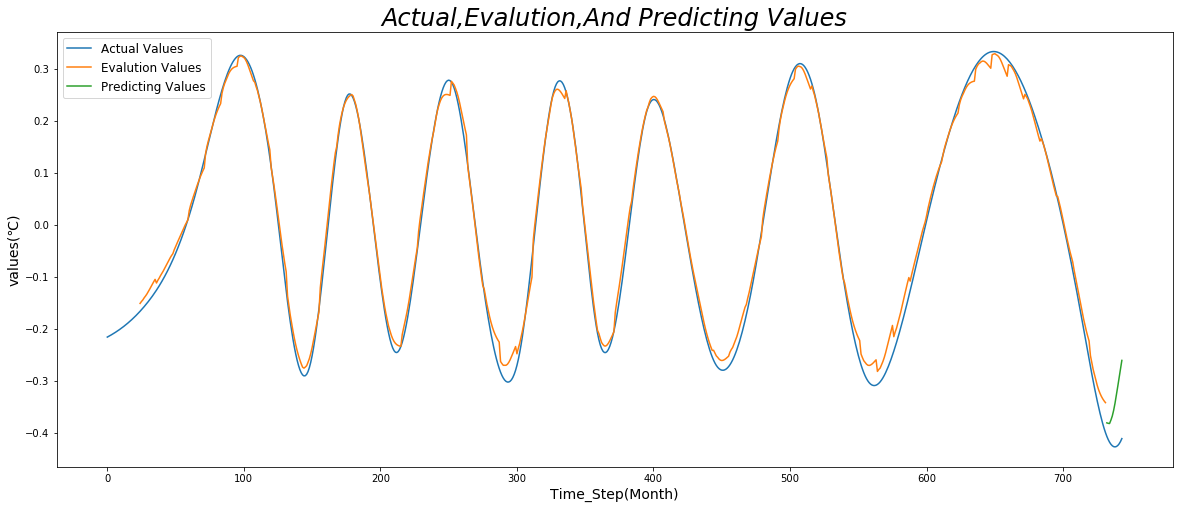

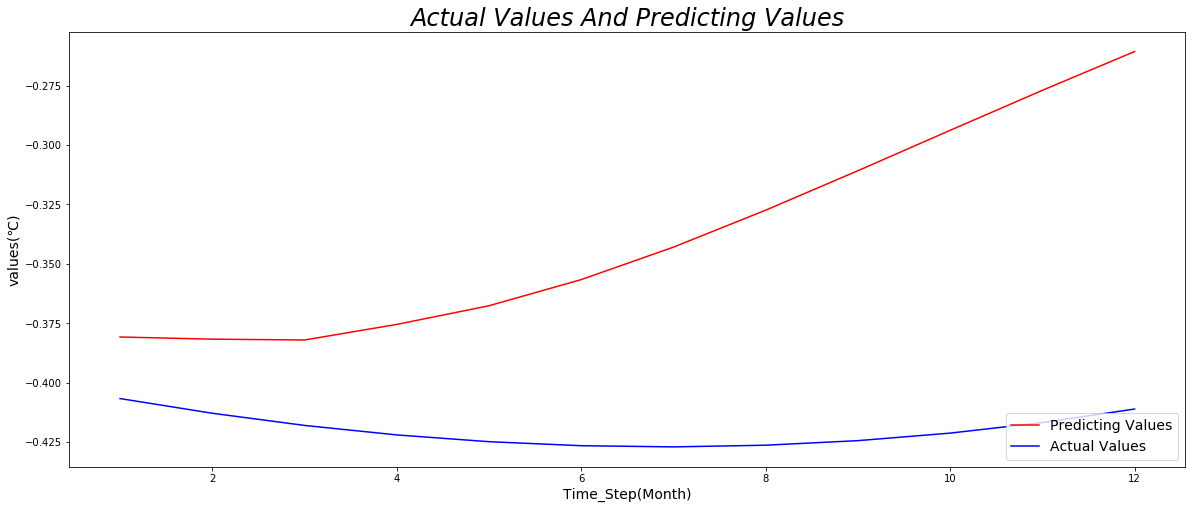

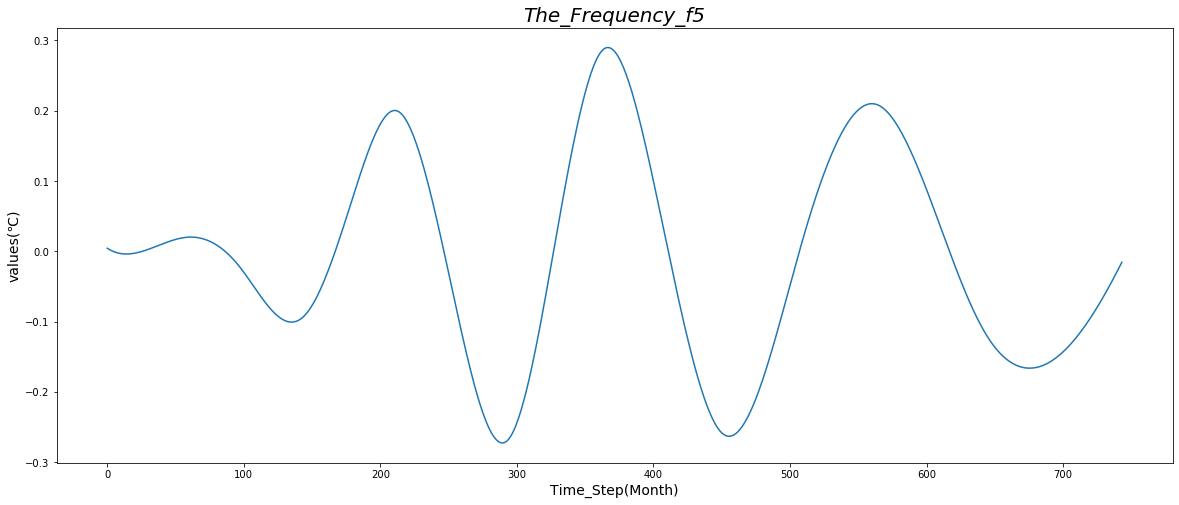

(696, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0151
Epoch 2/200
 - 5s - loss: 0.0069
Epoch 3/200
 - 5s - loss: 0.0021
Epoch 4/200
 - 5s - loss: 0.0013
Epoch 5/200
 - 5s - loss: 8.3351e-04
Epoch 6/200
 - 5s - loss: 6.5709e-04
Epoch 7/200
 - 5s - loss: 5.3617e-04
Epoch 8/200
 - 5s - loss: 5.3770e-04
Epoch 9/200
 - 5s - loss: 4.3857e-04
Epoch 10/200
 - 5s - loss: 3.9440e-04
Epoch 11/200
 - 4s - loss: 4.1501e-04
Epoch 12/200
 - 4s - loss: 4.6773e-04
Epoch 13/200
 - 4s - loss: 4.3264e-04
Epoch 14/200
 - 4s - loss: 5.1357e-04
Epoch 15/200
 - 4s - loss: 4.5901e-04
Epoch 16/200
 - 5s - loss: 3.8276e-04
Epoch 17/200
 - 5s - loss: 3.9469e-04
Epoch 18/200
 - 5s - loss: 3.5191e-04
Epoch 19/200
 - 5s - loss: 3.6012e-04
Epoch 20/200
 - 5s - loss: 3.1830e-04
Epoch 21/200
 - 5s - loss: 3.7507e-04
Epoch 22/200
 - 5s - loss: 4.0388e-04
Epoch 23/200
 - 5s - loss: 3.7875e-04
Epoch 24/200
 - 5s - loss: 4.8203e-04
Epoch 25/200
 - 5s - loss: 4.4587e-04
Epoch 26/200
 - 5s - loss: 4.6498e-04
Epoch 27/200
 - 5s - lo

(59, 12)


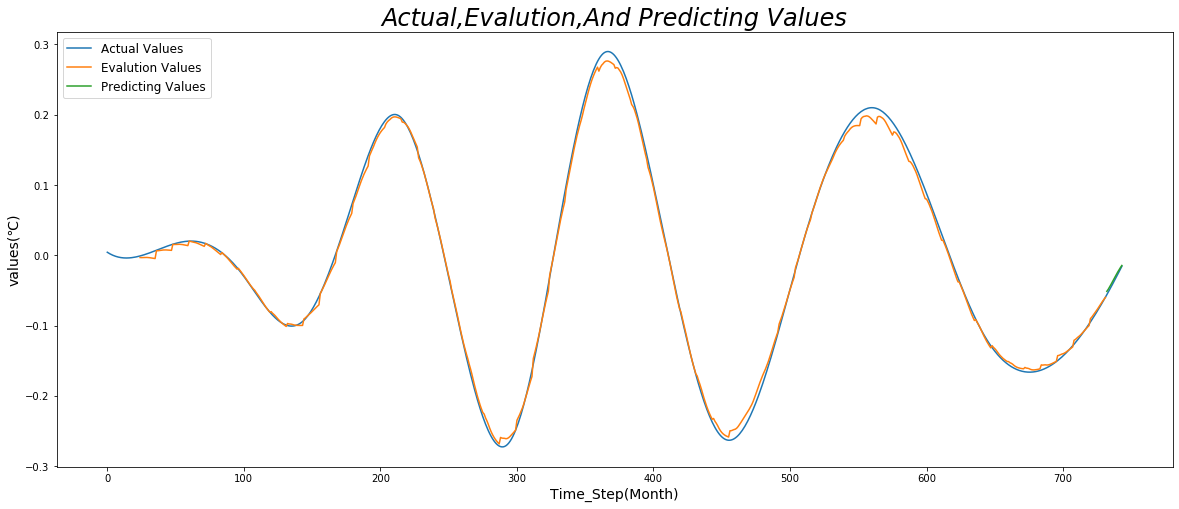

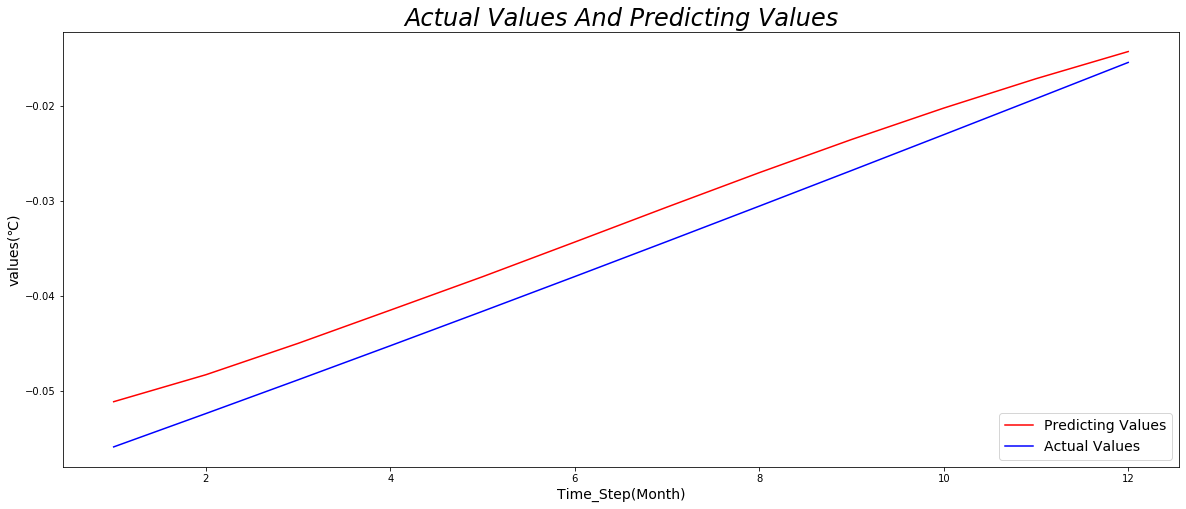

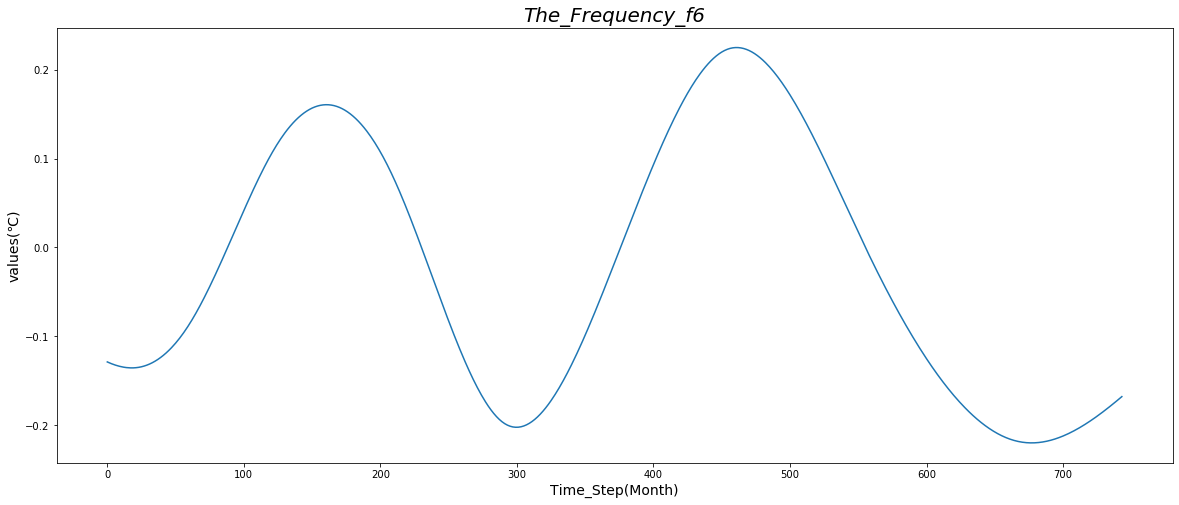

(696, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0089
Epoch 2/200
 - 6s - loss: 0.0034
Epoch 3/200
 - 6s - loss: 0.0019
Epoch 4/200
 - 6s - loss: 9.6334e-04
Epoch 5/200
 - 6s - loss: 5.5694e-04
Epoch 6/200
 - 6s - loss: 3.8952e-04
Epoch 7/200
 - 6s - loss: 3.4411e-04
Epoch 8/200
 - 6s - loss: 3.7784e-04
Epoch 9/200
 - 6s - loss: 2.9955e-04
Epoch 10/200
 - 6s - loss: 3.2276e-04
Epoch 11/200
 - 6s - loss: 3.2244e-04
Epoch 12/200
 - 6s - loss: 3.7098e-04
Epoch 13/200
 - 6s - loss: 6.2935e-04
Epoch 14/200
 - 6s - loss: 6.6902e-04
Epoch 15/200
 - 6s - loss: 4.4438e-04
Epoch 16/200
 - 5s - loss: 3.4360e-04
Epoch 17/200
 - 4s - loss: 2.7598e-04
Epoch 18/200
 - 4s - loss: 2.6927e-04
Epoch 19/200
 - 4s - loss: 2.7938e-04
Epoch 20/200
 - 5s - loss: 2.6928e-04
Epoch 21/200
 - 6s - loss: 2.7925e-04
Epoch 22/200
 - 6s - loss: 2.7235e-04
Epoch 23/200
 - 6s - loss: 2.3685e-04
Epoch 24/200
 - 6s - loss: 2.3847e-04
Epoch 25/200
 - 6s - loss: 2.1790e-04
Epoch 26/200
 - 6s - loss: 2.1501e-04
Epoch 27/200
 - 6s 

(59, 12)


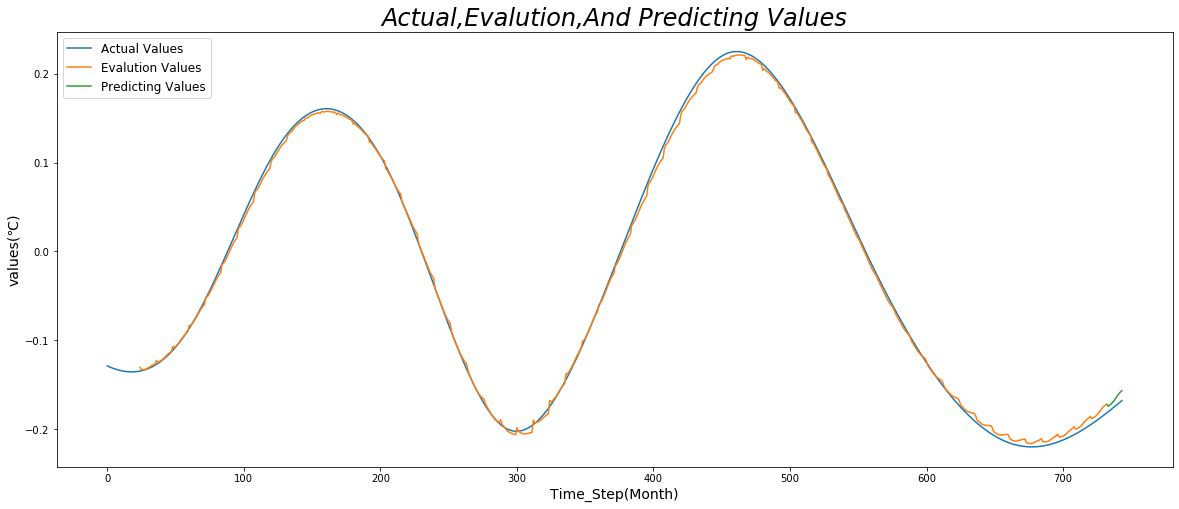

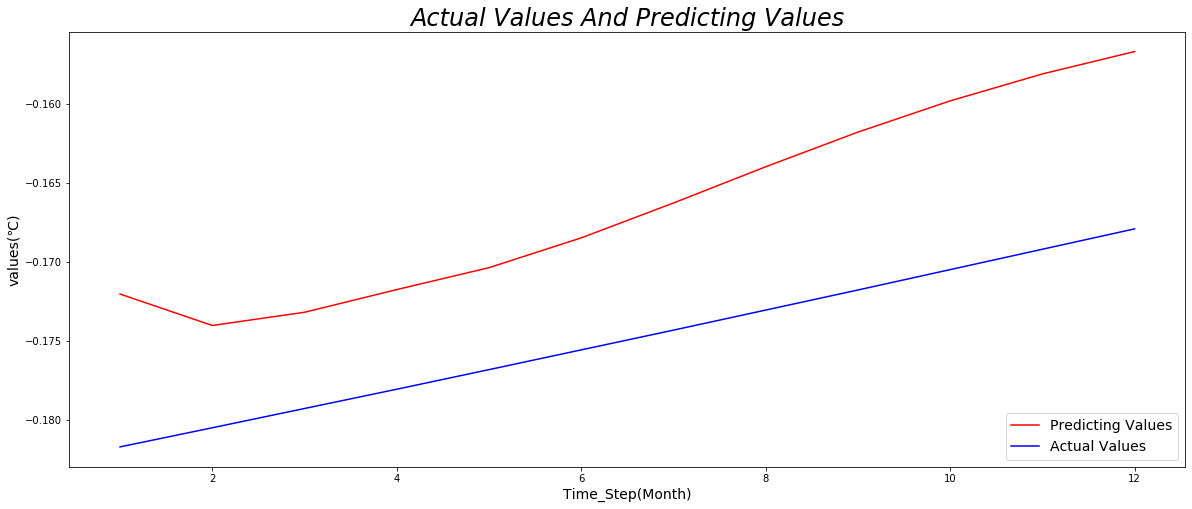

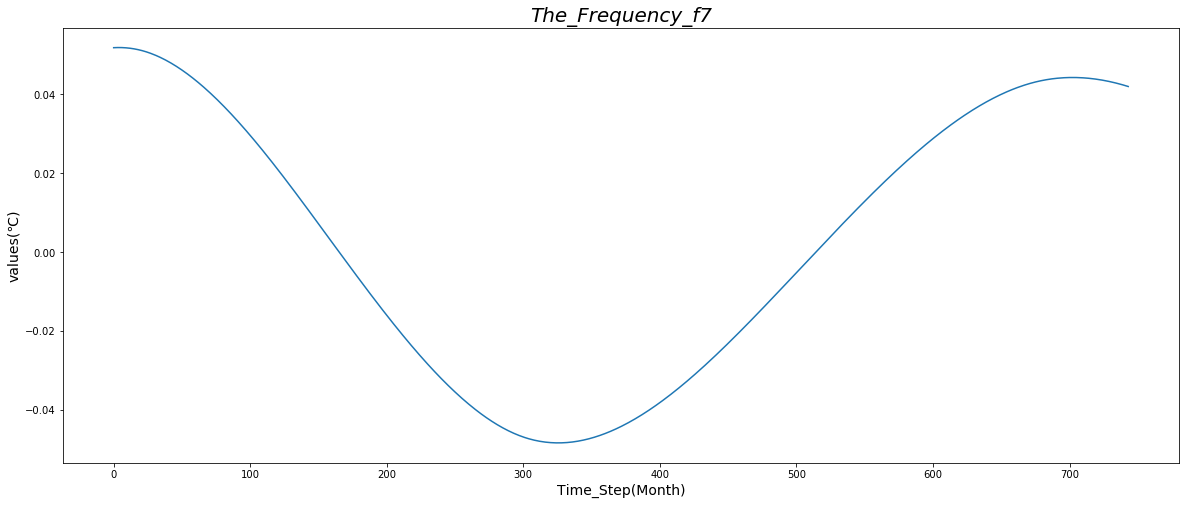

(696, 24, 1)
Epoch 1/200
 - 14s - loss: 8.3113e-04
Epoch 2/200
 - 6s - loss: 2.4228e-04
Epoch 3/200
 - 6s - loss: 1.4691e-04
Epoch 4/200
 - 6s - loss: 1.0279e-04
Epoch 5/200
 - 6s - loss: 8.0463e-05
Epoch 6/200
 - 6s - loss: 6.5063e-05
Epoch 7/200
 - 6s - loss: 6.4201e-05
Epoch 8/200
 - 6s - loss: 5.5780e-05
Epoch 9/200
 - 6s - loss: 4.4543e-05
Epoch 10/200
 - 6s - loss: 4.3979e-05
Epoch 11/200
 - 6s - loss: 4.2410e-05
Epoch 12/200
 - 6s - loss: 3.5995e-05
Epoch 13/200
 - 6s - loss: 4.2525e-05
Epoch 14/200
 - 6s - loss: 4.2129e-05
Epoch 15/200
 - 6s - loss: 3.7162e-05
Epoch 16/200
 - 6s - loss: 3.1854e-05
Epoch 17/200
 - 6s - loss: 2.2325e-05
Epoch 18/200
 - 5s - loss: 2.4201e-05
Epoch 19/200
 - 5s - loss: 3.5641e-05
Epoch 20/200
 - 5s - loss: 2.5187e-05
Epoch 21/200
 - 5s - loss: 1.9258e-05
Epoch 22/200
 - 6s - loss: 1.4351e-05
Epoch 23/200
 - 6s - loss: 1.5509e-05
Epoch 24/200
 - 6s - loss: 1.7415e-05
Epoch 25/200
 - 6s - loss: 1.6389e-05
Epoch 26/200
 - 6s - loss: 1.4200e-05
Epoch 2

(59, 12)


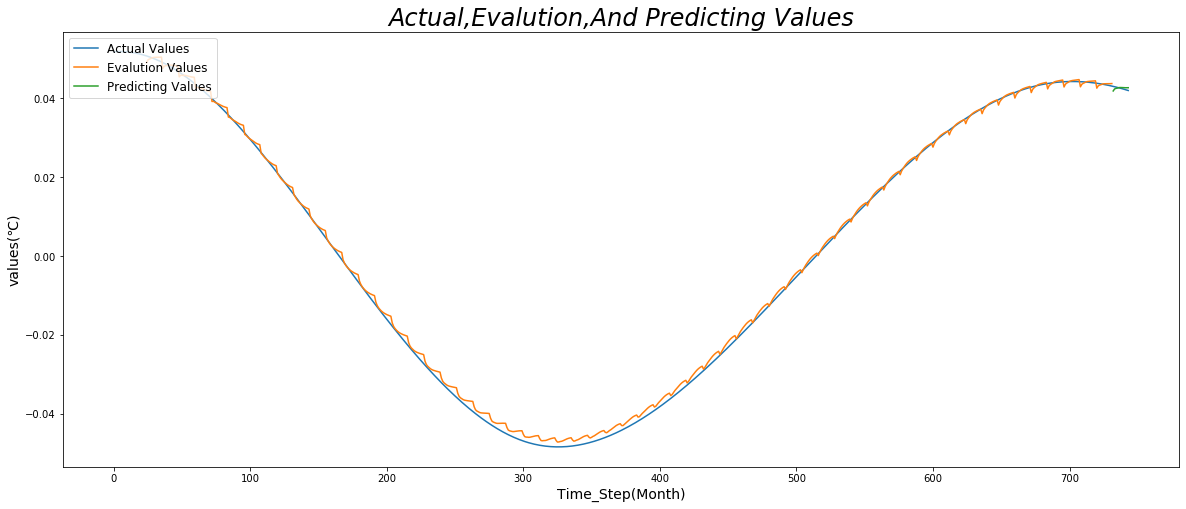

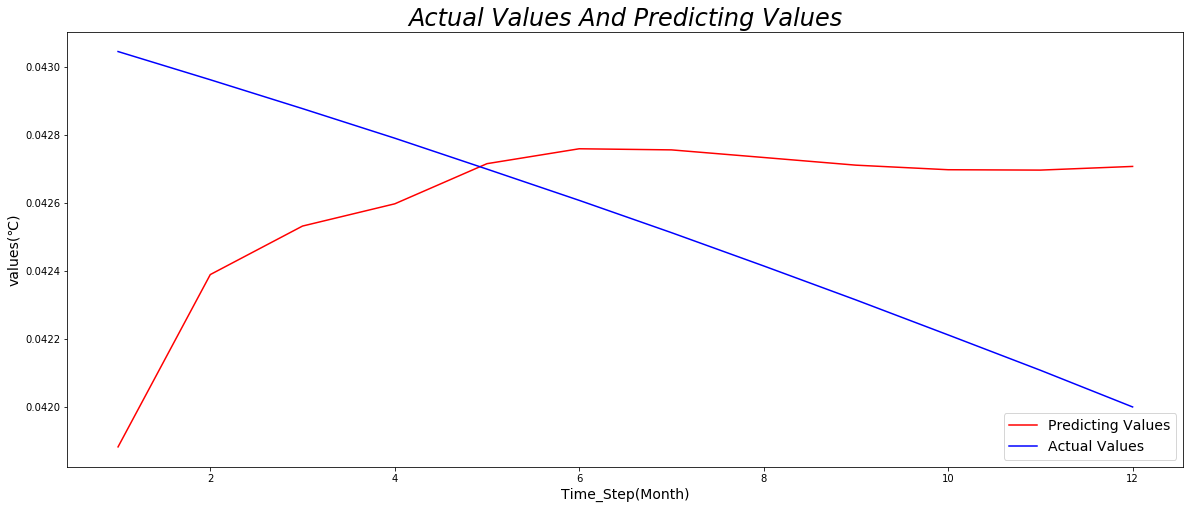

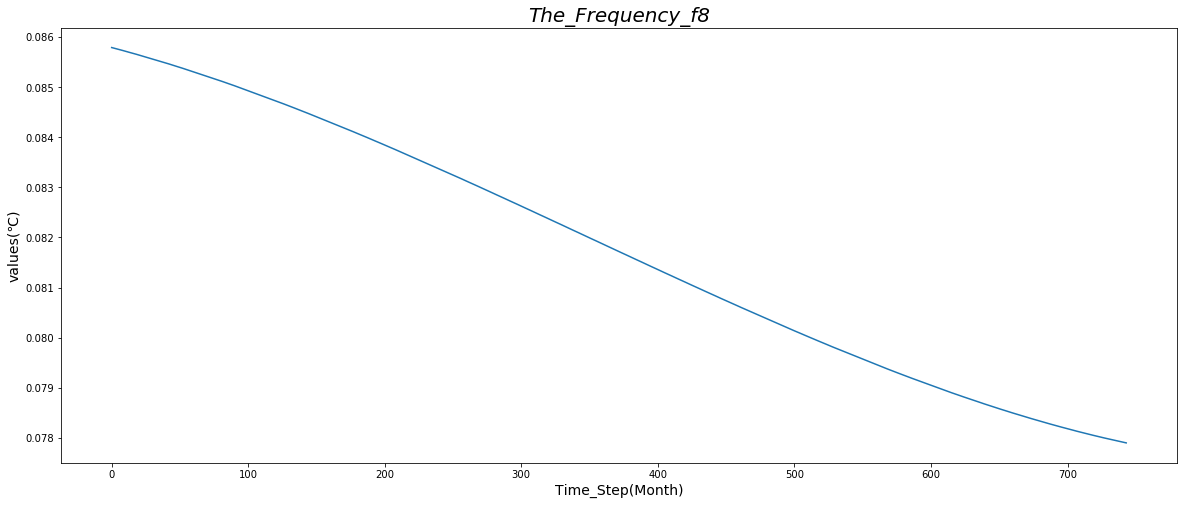

(696, 24, 1)
Epoch 1/200
 - 15s - loss: 5.9410e-04
Epoch 2/200
 - 7s - loss: 1.6140e-05
Epoch 3/200
 - 7s - loss: 7.9241e-06
Epoch 4/200
 - 7s - loss: 6.7790e-06
Epoch 5/200
 - 7s - loss: 6.5471e-06
Epoch 6/200
 - 7s - loss: 6.4893e-06
Epoch 7/200
 - 7s - loss: 6.3740e-06
Epoch 8/200
 - 5s - loss: 6.2316e-06
Epoch 9/200
 - 5s - loss: 6.0190e-06
Epoch 10/200
 - 5s - loss: 6.1955e-06
Epoch 11/200
 - 6s - loss: 6.0220e-06
Epoch 12/200
 - 7s - loss: 6.0161e-06
Epoch 13/200
 - 7s - loss: 5.8549e-06
Epoch 14/200
 - 7s - loss: 6.1705e-06
Epoch 15/200
 - 7s - loss: 6.0267e-06
Epoch 16/200
 - 7s - loss: 5.8835e-06
Epoch 17/200
 - 7s - loss: 5.9642e-06
Epoch 18/200
 - 7s - loss: 6.0050e-06
Epoch 19/200
 - 7s - loss: 5.9083e-06
Epoch 20/200
 - 7s - loss: 5.8645e-06
Epoch 21/200
 - 7s - loss: 5.7811e-06
Epoch 22/200
 - 7s - loss: 5.6823e-06
Epoch 23/200
 - 7s - loss: 5.9385e-06
Epoch 24/200
 - 7s - loss: 5.8188e-06
Epoch 25/200
 - 7s - loss: 5.8378e-06
Epoch 26/200
 - 7s - loss: 5.8779e-06
Epoch 2

(59, 12)


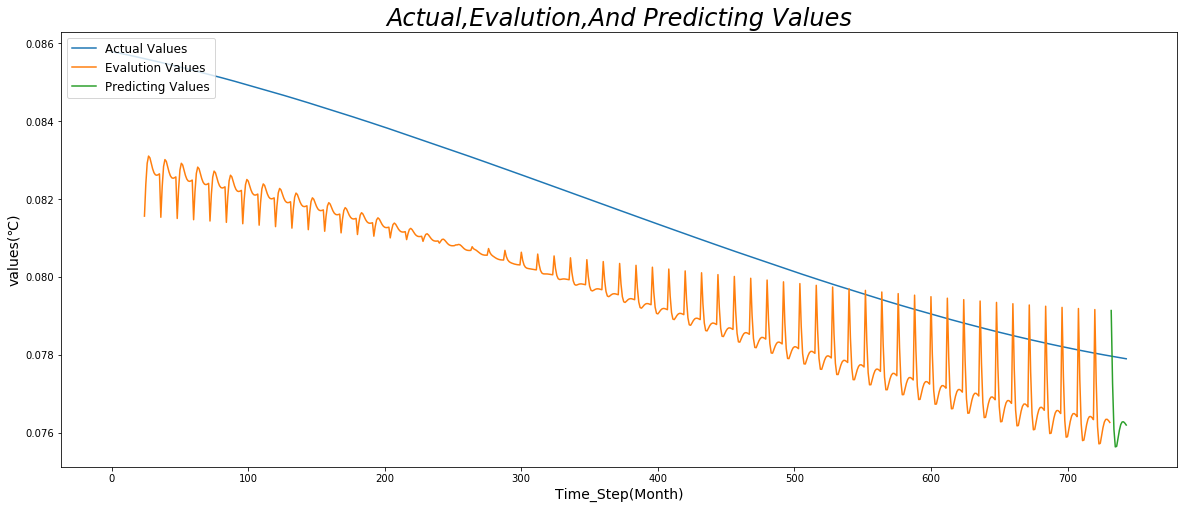

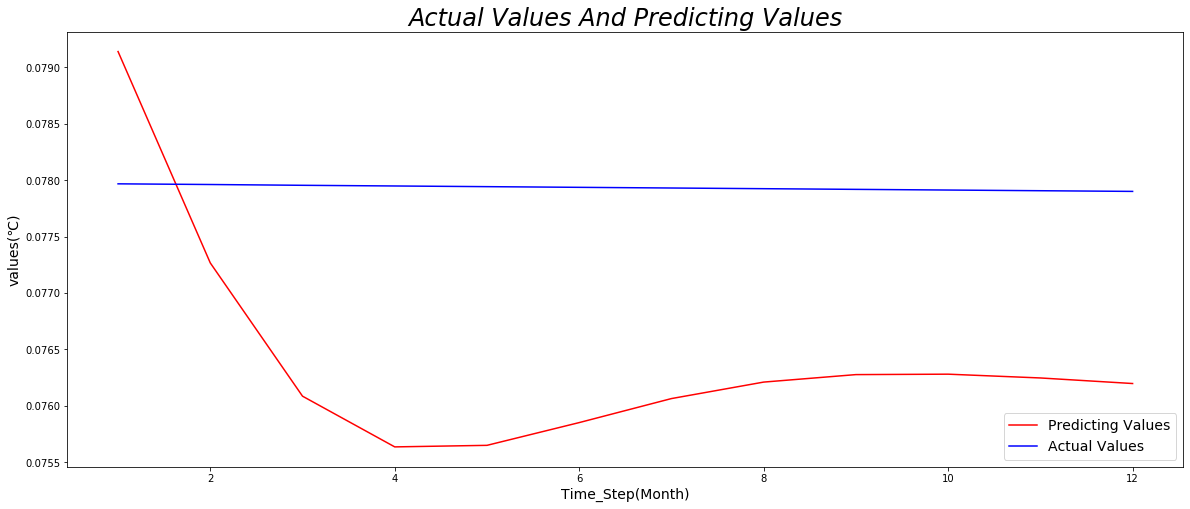

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-84]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07913885]
 [0.07726634]
 [0.07608593]
 [0.07563668]
 [0.07565043]
 [0.075852  ]
 [0.07606471]
 [0.07621077]
 [0.07627705]
 [0.07628085]
 [0.0762473 ]
 [0.07619803]]
[array([-0.23724 , -0.023669,  0.17807 ,  0.28268 ,  0.30486 ,  0.35933 ,
        0.25548 ,  0.081523, -0.079644, -0.24512 , -0.2287  , -0.13405 ]), array([-0.096603,  0.071551,  0.22977 ,  0.36117 ,  0.4489  ,  0.47608 ,
        0.43172 ,  0.32912 ,  0.19031 ,  0.03803 , -0.10826 , -0.23926 ]), array([-0.39588, -0.46723, -0.52313, -0.56213, -0.58275, -0.58331,
       -0.56179, -0.51852, -0.45721, -0.38223, -0.29798, -0.20885]), array([-0.14698 , -0.15581 , -0.15941 , -0.15714 , -0.14834 , -0.13253 ,
       -0.1102  , -0.082479, -0.050654, -0.015994,  0.020232,  0.056753]), array([-0.40672, -0.4129 , -0.41802, -0.42202, -0.42487, -0.42656,
       -0.42706, -0.42635, -0.42443, -0.42126, -0.41683, -0.41112]), array([-0.055875, -0.05237 , -0.048826, -0.045243, -0.041624, -0.037971,
       -0.034286, -0.030572, -0.026831, -

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.23724  -0.023669  0.17807   0.28268   0.30486   0.35933   0.25548
  0.081523 -0.079644 -0.24512  -0.2287   -0.13405 ]
[[-0.23724 ]
 [-0.023669]
 [ 0.17807 ]
 [ 0.28268 ]
 [ 0.30486 ]
 [ 0.35933 ]
 [ 0.25548 ]
 [ 0.081523]
 [-0.079644]
 [-0.24512 ]
 [-0.2287  ]
 [-0.13405 ]]
[[-0.24]
 [-0.02]
 [ 0.18]
 [ 0.28]
 [ 0.3 ]
 [ 0.36]
 [ 0.26]
 [ 0.08]
 [-0.08]
 [-0.25]
 [-0.23]
 [-0.13]]
-----------------------------------
observe value:[-0.096603  0.071551  0.22977   0.36117   0.4489    0.47608   0.43172
  0.32912   0.19031   0.03803  -0.10826  -0.23926 ]
[[-0.333843]
 [ 0.047882]
 [ 0.40784 ]
 [ 0.64385 ]
 [ 0.75376 ]
 [ 0.83541 ]
 [ 0.6872  ]
 [ 0.410643]
 [ 0.110666]
 [-0.20709 ]
 [-0.33696 ]
 [-0.37331 ]]
[[-0.33]
 [ 0.05]
 [ 0.41]
 [ 0.64]
 [ 0.75]
 [ 0.84]
 [ 0.69]
 [ 0.41]
 [ 0.11]
 [-0.21]
 [-0.34]
 [-0.37]]
-----------------------------------
observe value:[-0.39588 -0.46723 -0.52313 -0.56213 -0.58275 -0.58331 -0.56179 -0.51852
 -0.45721 -0.38223 -0.29798 -0.20885]

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.00420944  0.2539794   0.34894234  0.3541326   0.29062426  0.11244959
 -0.12356974 -0.2625394  -0.26373133 -0.08660804  0.13442494  0.20592882]
[ 0.00420944  0.25397941  0.34894234  0.35413259  0.29062426  0.11244959
 -0.12356974 -0.26253939 -0.26373133 -0.08660804  0.13442494  0.20592882]
the 1 frequence:
predicted_value:[-0.08335851  0.10799135  0.3054218   0.44518334  0.51326865  0.50807464
  0.43031943  0.288281    0.10468397 -0.08367828 -0.23535927 -0.31539533]
[-0.07914907  0.36197076  0.65436414  0.79931593  0.80389291  0.62052424
  0.30674969  0.02574161 -0.15904736 -0.17028633 -0.10093433 -0.10946651]
the 2 frequence:
predicted_value:[-0.37140667 -0.4125974  -0.3956456  -0.33387357 -0.2402194  -0.12691271
 -0.00930807  0.09614753  0.17605768  0.22288069  0.23553656  0.21857661]
[-0.45055574 -0.05062663  0.25871855  0.46544236  0.56367351  0.49361152
  0.29744162  0.12188914  0.01701032  0.05259436  0.134

[[-1.4]
 [-1.1]
 [-0.8]
 [-0.6]
 [-0.5]
 [-0.4]
 [-0.5]
 [-0.7]
 [-0.9]
 [-1.1]
 [-1.1]
 [-1. ]]
[-1.06568609 -0.68349718 -0.3745988  -0.15750404 -0.04802621 -0.10327129
 -0.28102393 -0.43487867 -0.51535505 -0.45333058 -0.34357346 -0.34077357]


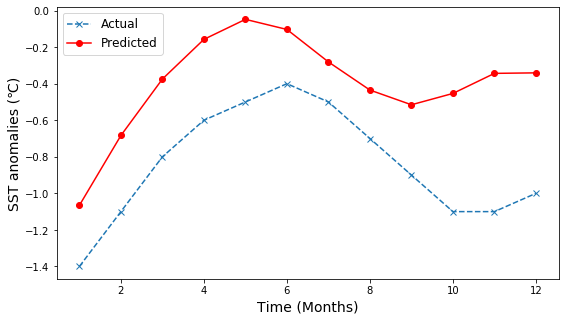

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


In [ ]:
[-1.06568609,-0.68349718,-0.3745988,-0.15750404,-0.04802621,-0.10327129,-0.28102393,-0.43487867,-0.51535505,-0.45333058,-0.34357346,-0.34077357]
